In [71]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping, to_torch
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from sklearn.manifold import TSNE
import pandas as pd

In [12]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }

output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "HR"
experiment_id = "9_COMPARISON_2"
#experiment_id = "10_COMPARISON_2"

#dataset_name = "POLLUTION"
#experiment_id = "1_COMPARISON_2"

#dataset_name = "BATTERY"
#experiment_id = "17_COMPARISON_1"

#load_model_file = "9_COMPARISON_2_model.pt"
lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [13]:

trial = 0
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_encoder = output_directory + experiment_id + "_encoder_model.pt"
save_model_file_ = output_directory + experiment_id + "_model.pt"


model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
output_layer = nn.Linear(120, 1)

model.cuda()
output_layer.cuda()

#output_layer.load_state_dict(torch.load(save_model_file_))

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_encoder))
maml.load_state_dict(torch.load(save_model_file_))

total_tasks_test = len(test_data_ML)
error_list =  []
parameters_list = []
domain_list = []
error_mean = []
activations_list = []

learner = maml.clone()  # Creates a clone of model
learner.cuda()
count = 0.0


input_dim = test_data_ML.x.shape[-1]
window_size = test_data_ML.x.shape[-2]
output_dim = test_data_ML.y.shape[-1]

if is_test:
    step = total_tasks_test//100

else:
    step = 1

step = 1 if step == 0 else step
step = 1
max_tasks = (total_tasks_test-horizon-1)


temp_params = []
for params in maml.parameters():

    temp_params.append(params.cpu().detach().numpy()[0])
params = np.concatenate([temp_params[0], np.array([temp_params[1]])])
parameters_list.append(list(params))
domain_list.append(test_data_ML.file_idx[-1])
idx_list = [0]

for task in range(0,max_tasks , step):

    temp_file_idx = test_data_ML.file_idx[task:task+horizon+1]
    if(len(np.unique(temp_file_idx))>1):
        continue

    idx_list.append(test_data_ML.file_idx[task])
    #model = LSTMModel( batch_size=None, seq_len = None, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)

    learner = maml.clone() 

    x_spt, y_spt = test_data_ML[task]
    x_qry = test_data_ML.x[(task+1):(task+1+horizon)].reshape(-1, window_size, input_dim)
    y_qry = test_data_ML.y[(task+1):(task+1+horizon)].reshape(-1, output_dim)



    x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
    x_qry = to_torch(x_qry)
    y_qry = to_torch(y_qry)


    for step in range(adaptation_steps):


        pred = learner(model.encoder(x_spt))
        error = mae(pred, y_spt)
        learner.adapt(error)


    error_mean.append(np.mean(error.cpu().detach().numpy()))
    temp_params = []
    for params in maml.parameters():

        temp_params.append(params.cpu().detach().numpy()[0])
    params = np.concatenate([temp_params[0], np.array([temp_params[1]])])
    parameters_list.append(list(params))
    domain_list.append(test_data_ML.file_idx[task])
    activations_list.append(model.encoder(x_spt).cpu().detach().numpy()[np.newaxis, :])
    
    

# Activations analysis

In [99]:
activations = np.concatenate(activations_list)
activations.shape

(286, 50, 120)

In [112]:
activations_mean = np.mean(activations**2, axis=1)
activations_mean.shape

(286, 120)

In [113]:
activations_mean2 = np.mean(activations_mean, axis=1)

(array([ 1.,  0.,  2.,  5.,  8.,  6.,  2.,  0.,  1.,  0.,  1.,  0.,  2.,
         5.,  5.,  4.,  3.,  8.,  6.,  8.,  5.,  5.,  2.,  5.,  4.,  3.,
         5., 10., 11.,  8.,  8., 11., 13.,  7., 12.,  7.,  4.,  5.,  3.,
         3.,  3.,  5.,  2.,  5.,  3.,  2.,  5.,  2.,  2.,  4.,  5.,  3.,
         1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  2.,  1.,
         1.,  1.,  4.,  4.,  1.,  1.,  2.,  1.,  1.,  0.,  2.,  1.,  2.,
         0.,  1.,  2.,  0.,  0.,  2.,  0.,  2.,  3.]),
 array([0.02193991, 0.02319667, 0.02445342, 0.02571017, 0.02696693,
        0.02822368, 0.02948043, 0.03073719, 0.03199394, 0.03325069,
        0.03450745, 0.0357642 , 0.03702096, 0.03827771, 0.03953446,
        0.04079121, 0.04204797, 0.04330472, 0.04456148, 0.04581823,
        0.04707498, 0.04833173, 0.04958849, 0.05084524, 0.052102  ,
        0.05335875, 0.0546155 , 0.05587225, 0.05712901, 0.05838576,
        0.05964252, 0.0608

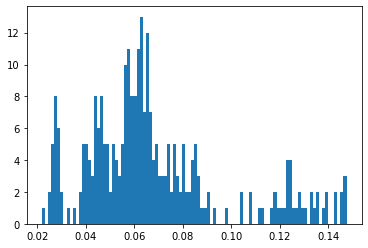

In [115]:
plt.hist(activations_mean2, bins=100)

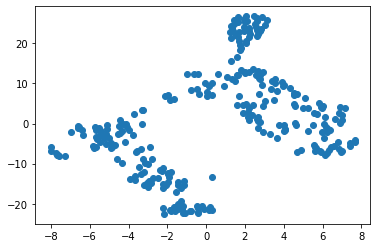

In [117]:
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(activations_mean)

plt.scatter(X_embedded[:,0], X_embedded[:,1])

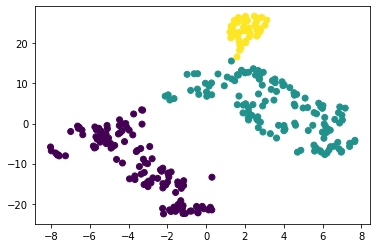

In [118]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2.5, min_samples=5).fit(X_embedded)
labels = db.labels_
labels
n_labels = np.max(labels)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c= labels)

# Parameters analysis

In [119]:
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2).fit_transform(parameters_list)



Text(0.5, 1.0, 'HR-MAML-PARAMETERS-ALL-DOMAIN')

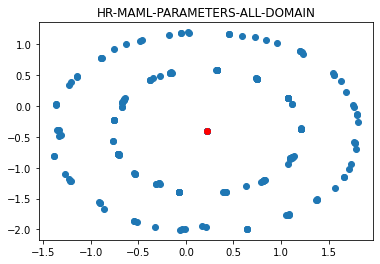

In [120]:
%matplotlib inline
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.scatter(X_embedded[0,0], X_embedded[0,1], c="red")
name = dataset_name+"-MAML-PARAMETERS-ALL-DOMAIN"
plt.title(name)
#plt.savefig("../../Results/figures/"+name+".png")

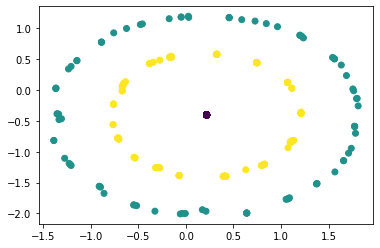

In [128]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.47, min_samples=4).fit(X_embedded)
labels_parameters = db.labels_


plt.scatter(X_embedded[:,0], X_embedded[:,1], c= labels_parameters)

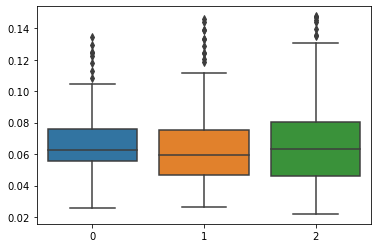

In [129]:
import seaborn as sns
sns.boxplot(x=labels_parameters[1:], y=activations_mean2)

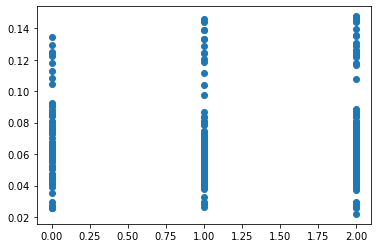

In [132]:
plt.scatter(labels_parameters[1:], activations_mean2)

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

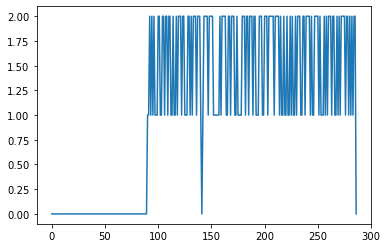

In [139]:

plt.plot(labels_parameters)

In [141]:
labels_parameters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1,
       2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       0], dtype=int64)

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

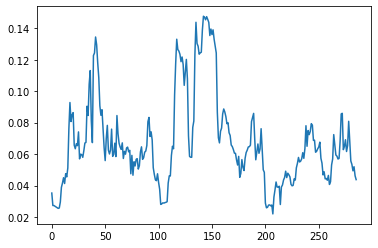

In [138]:
plt.plot(activations_mean2)

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backends\backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\matplotlib\backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

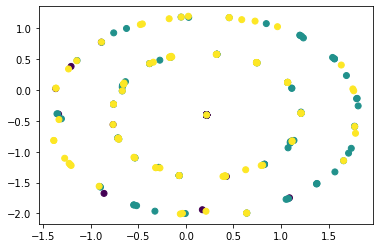

In [137]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(idx_list)))
plt.scatter(X_embedded[:,0],  X_embedded[:,1], c=idx_list)


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


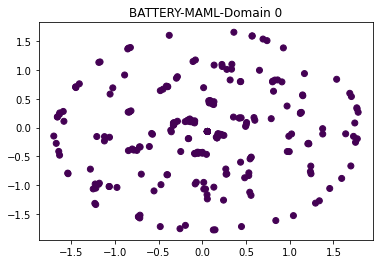

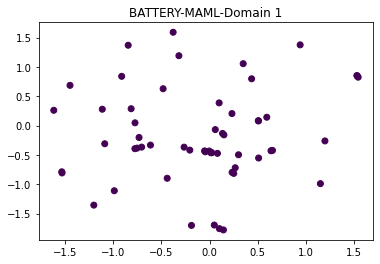

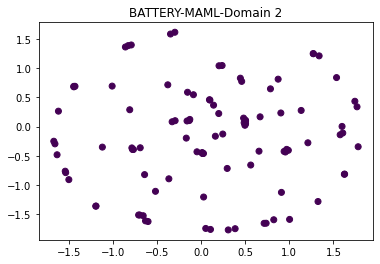

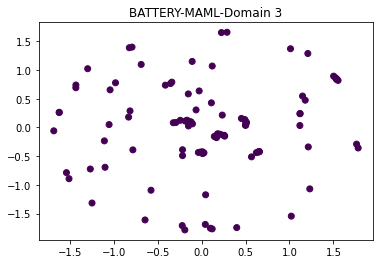

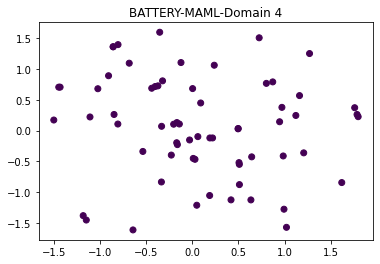

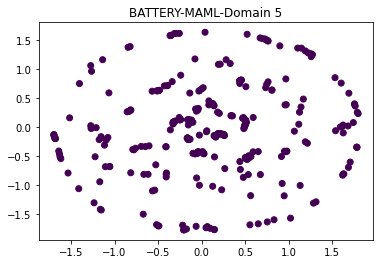

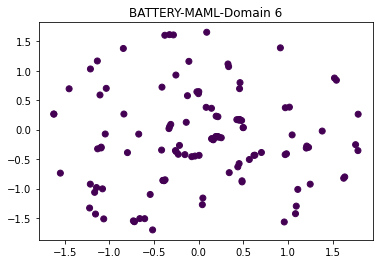

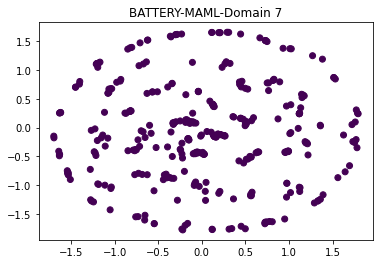

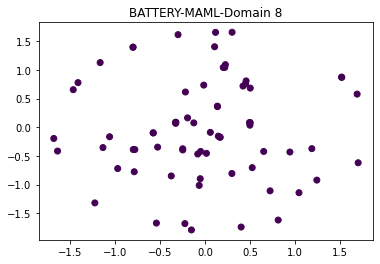

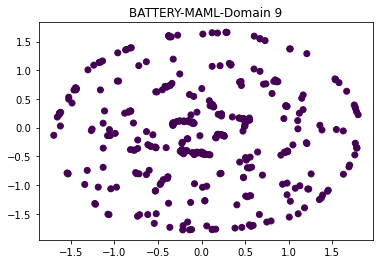

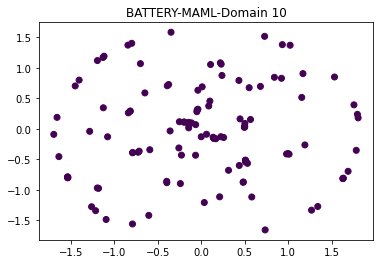

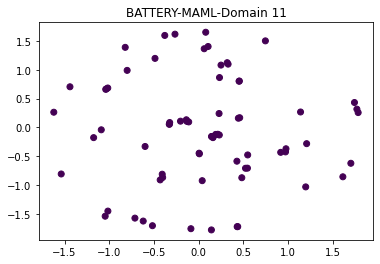

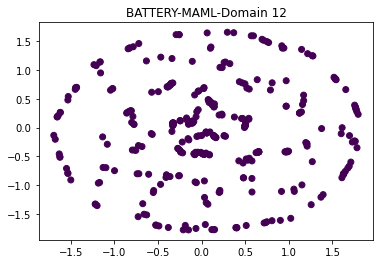

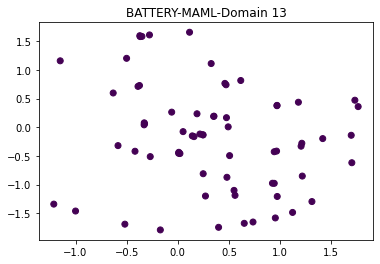

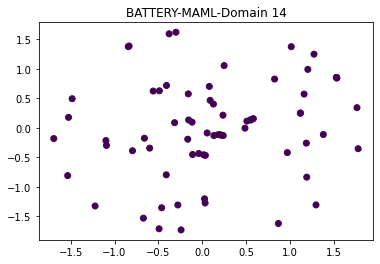

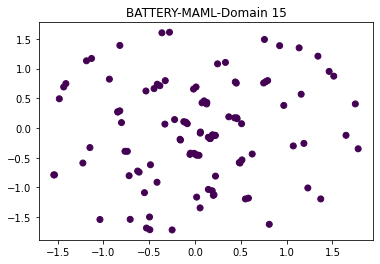

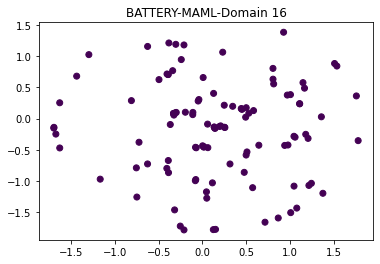

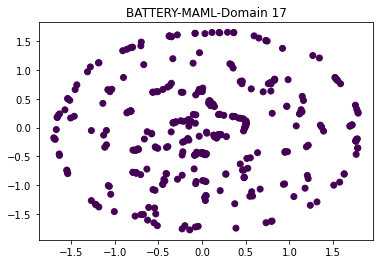

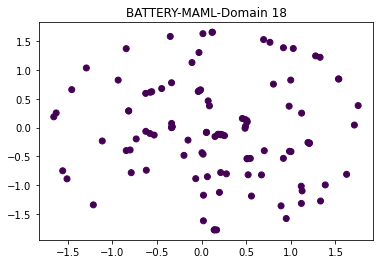

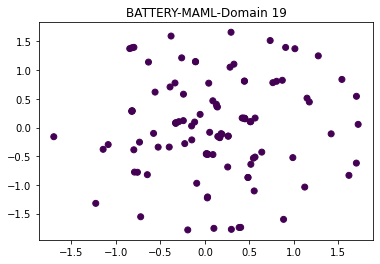

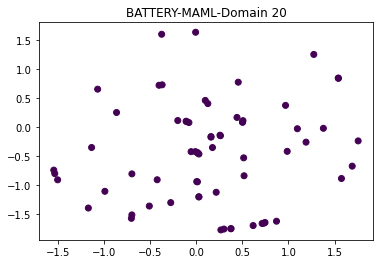

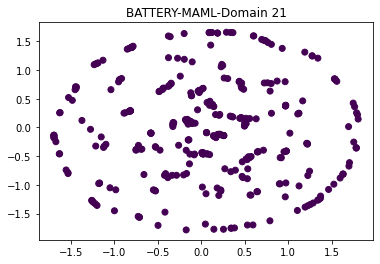

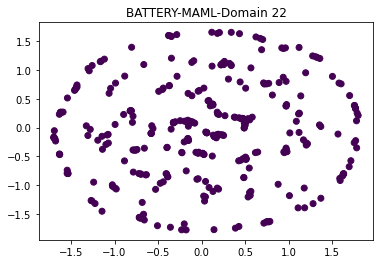

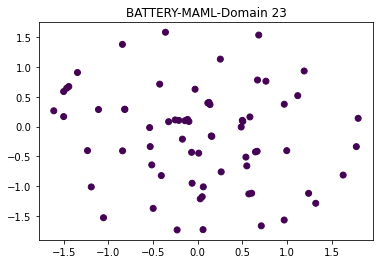

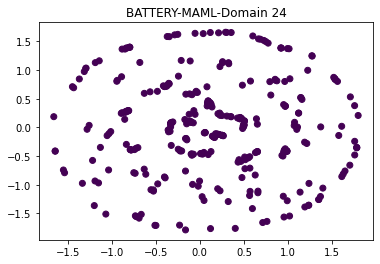

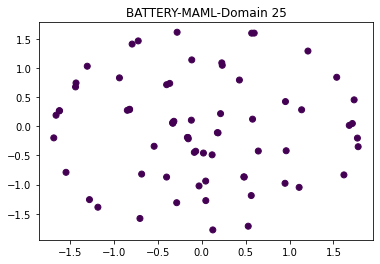

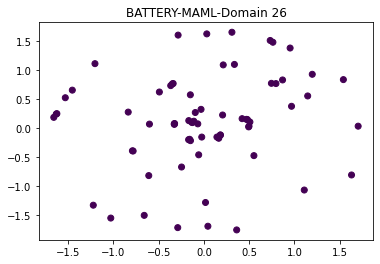

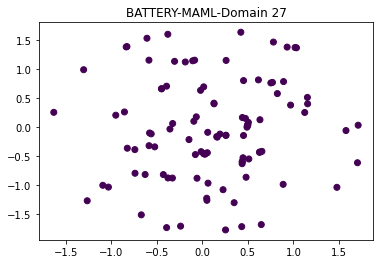

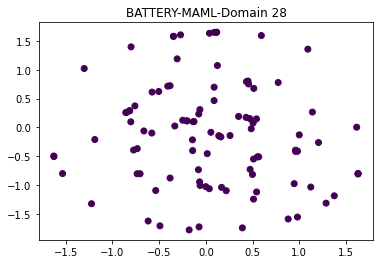

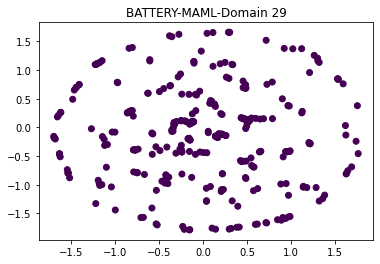

In [70]:
for idx in range(max(idx_list)+1):
    
    fig = plt.figure()
    idx_select = np.where(np.array(idx_list)==idx)[0]
    plt.scatter(X_embedded[idx_select,0],  X_embedded[idx_select,1], c=np.array(idx_list)[idx_select])
    plt.title(dataset_name+"-MAML-Domain "+str(idx))
    plt.savefig("../../Results/figures/"+dataset_name+"-MAML-Domain "+str(idx)+"-10.jpg")

In [24]:
idx_select

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [15]:
idx_select

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [6]:

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = numpy.fromstring ( fig.canvas.tostring_argb(), dtype=numpy.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = numpy.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [7]:
plt.show()

In [8]:
import numpy
from PIL import Image


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


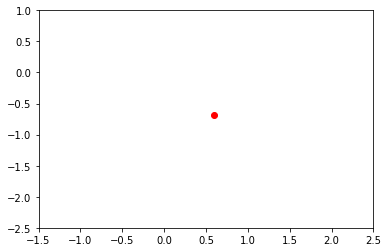

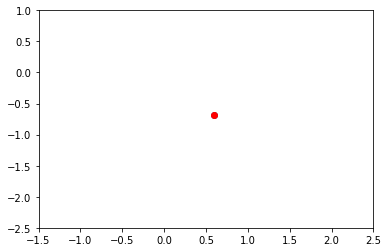

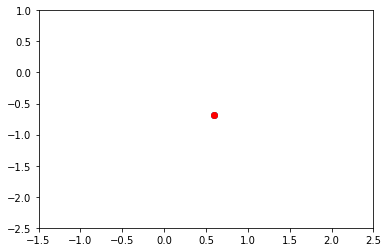

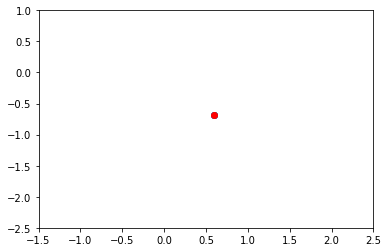

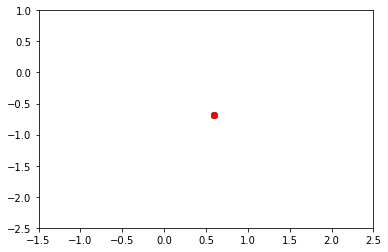

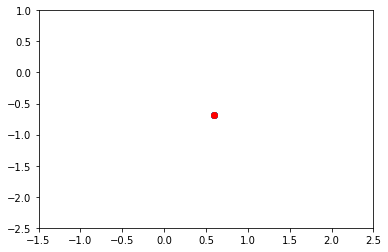

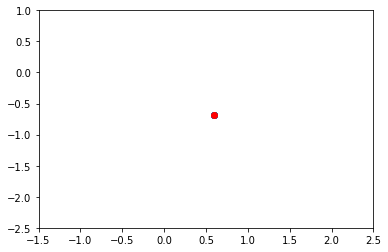

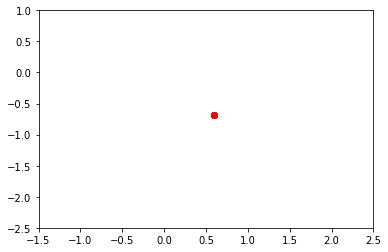

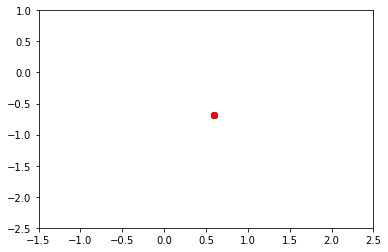

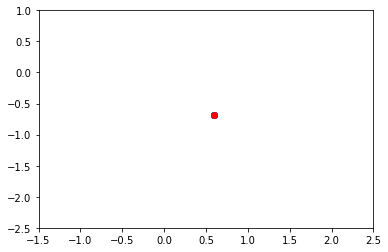

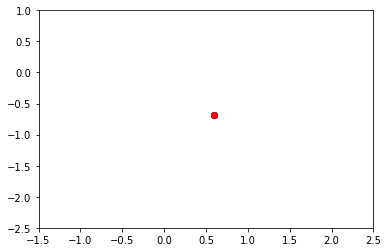

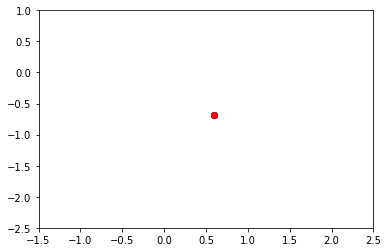

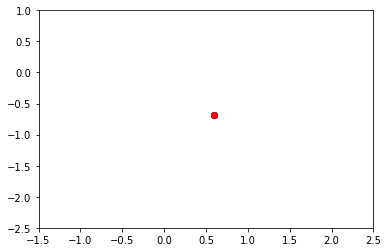

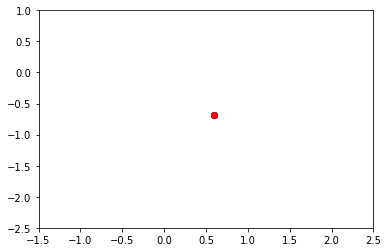

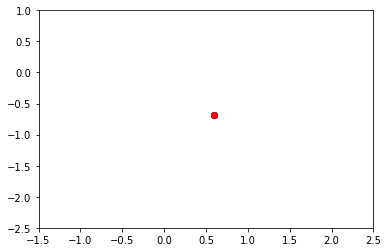

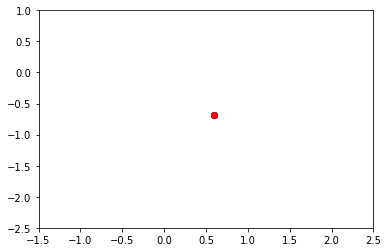

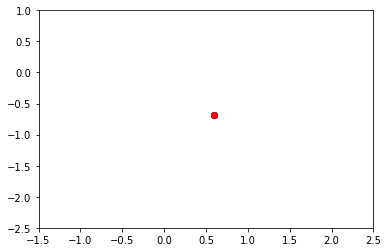

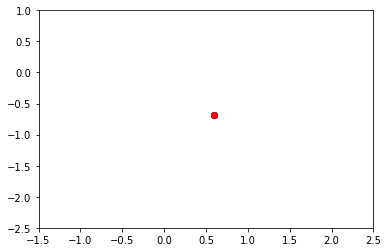

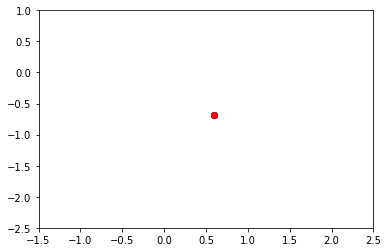

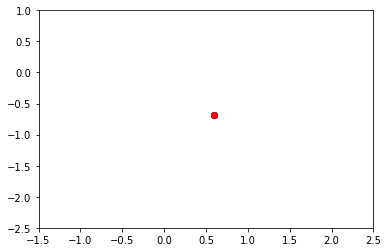

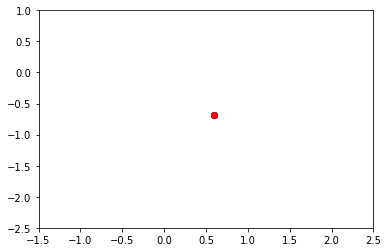

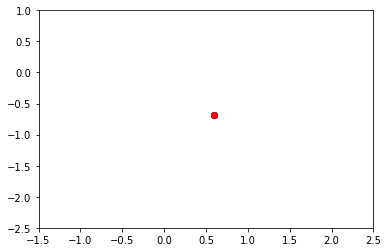

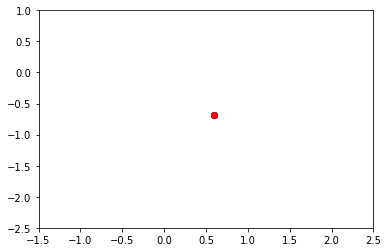

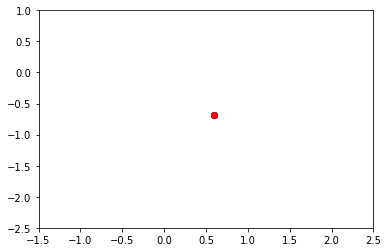

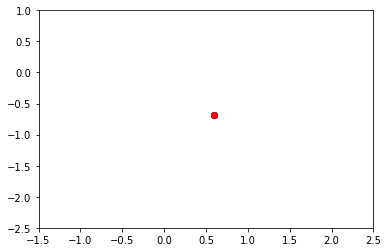

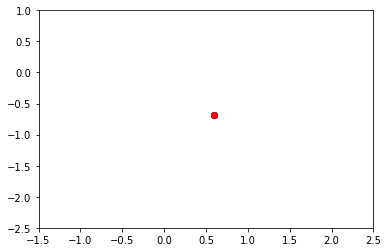

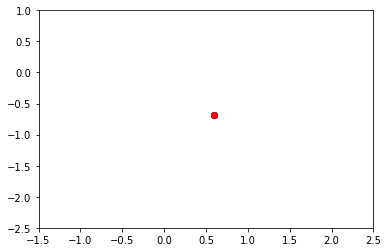

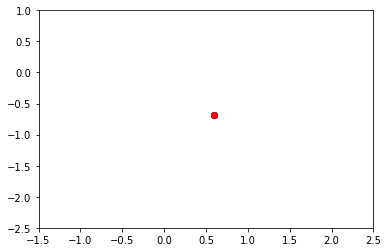

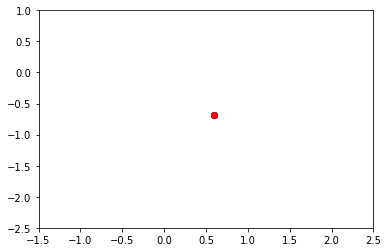

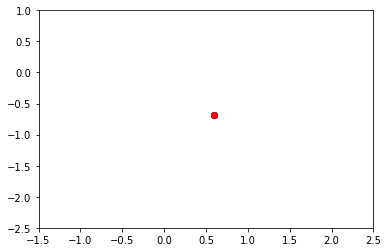

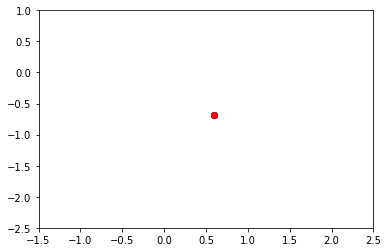

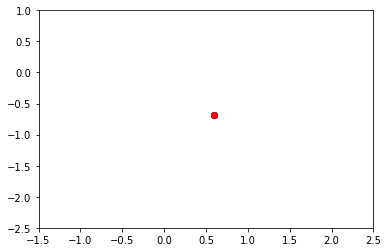

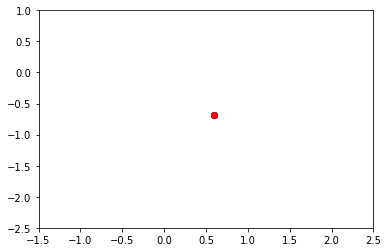

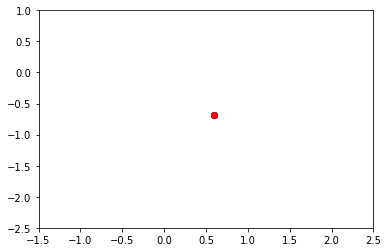

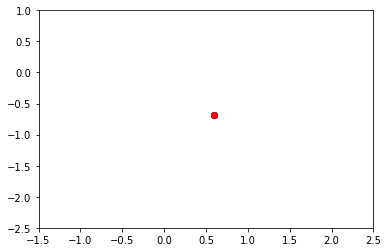

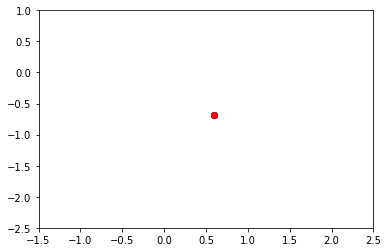

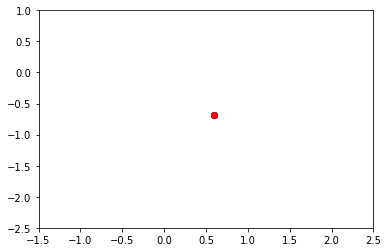

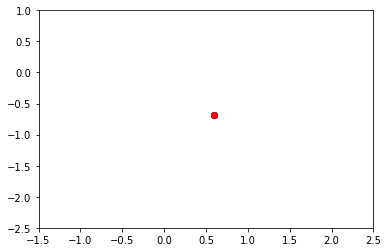

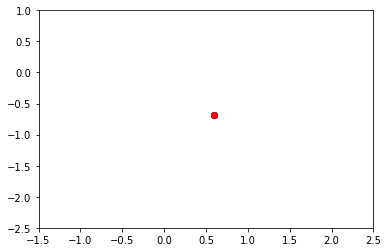

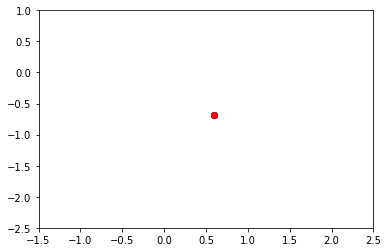

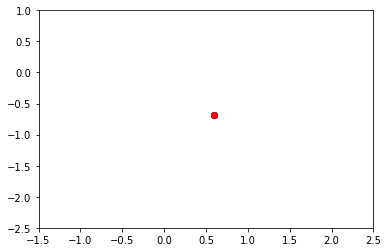

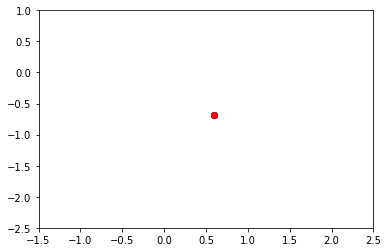

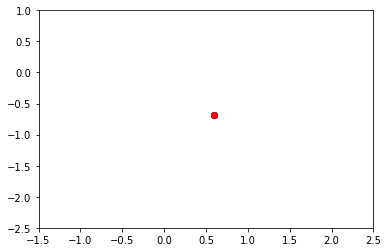

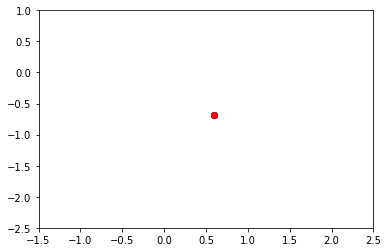

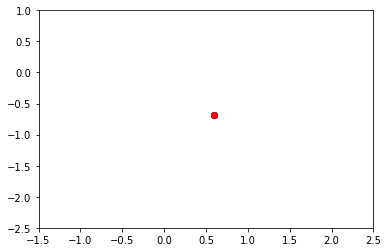

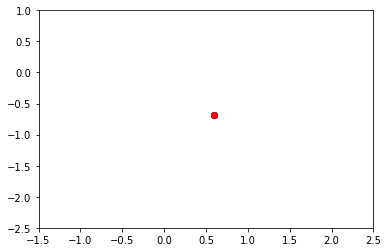

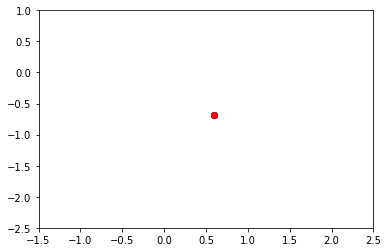

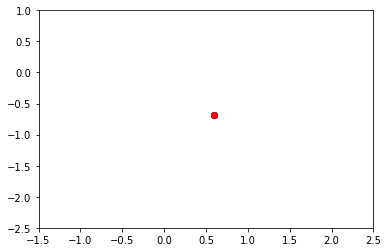

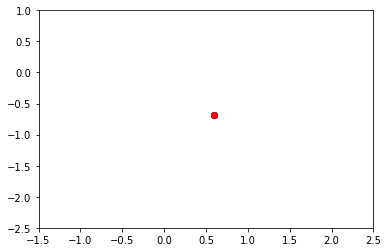

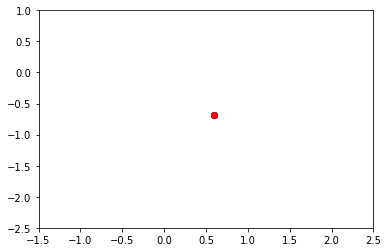

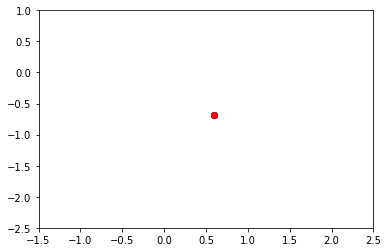

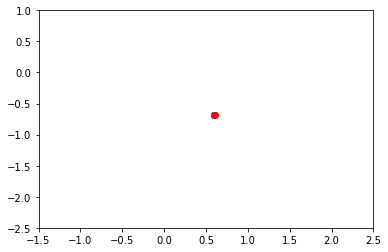

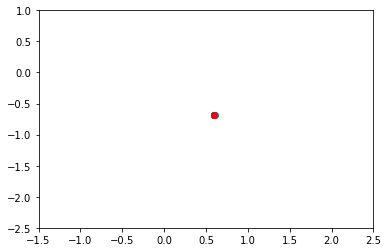

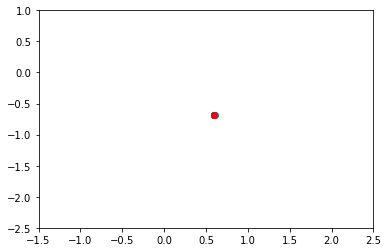

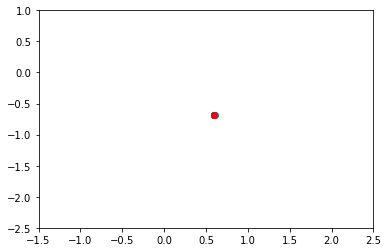

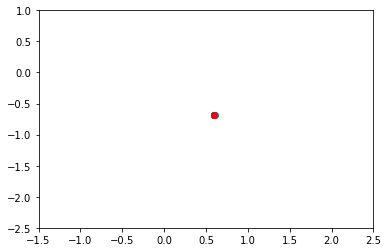

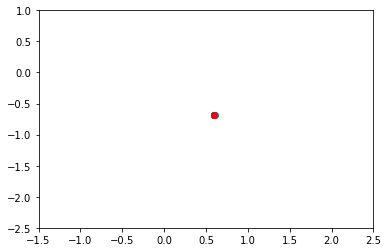

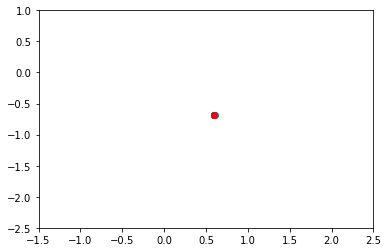

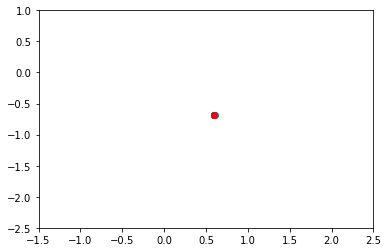

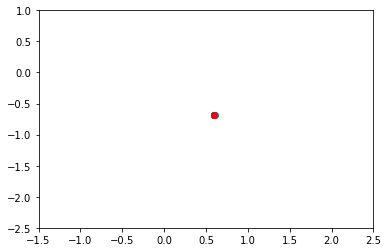

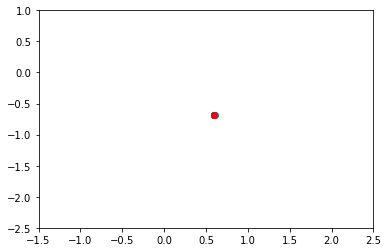

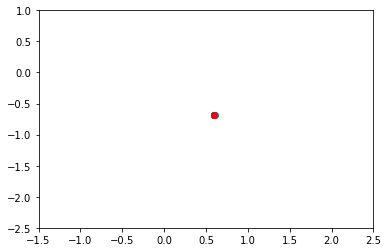

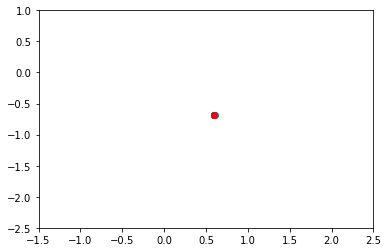

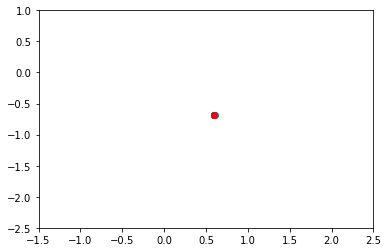

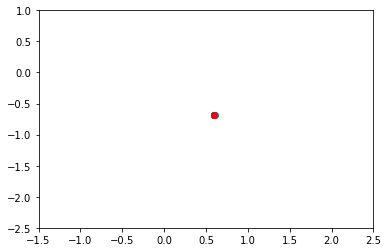

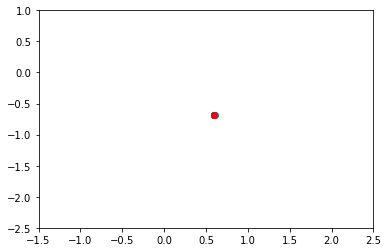

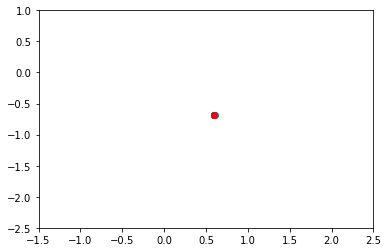

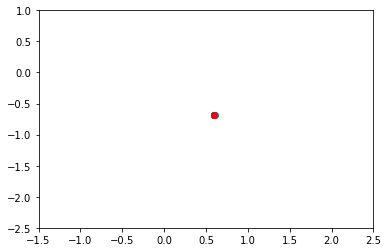

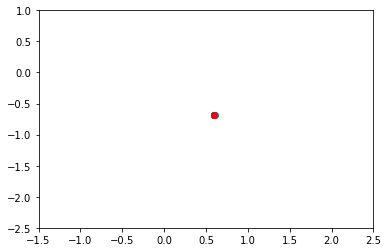

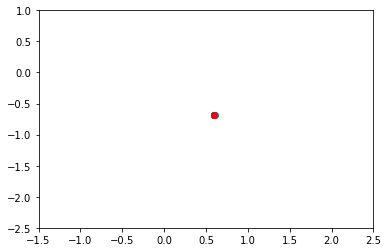

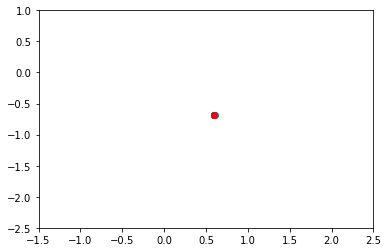

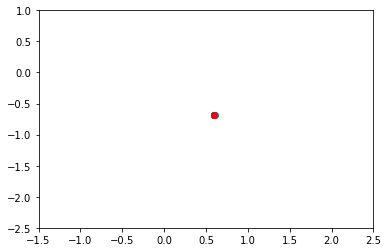

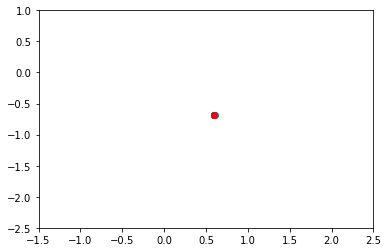

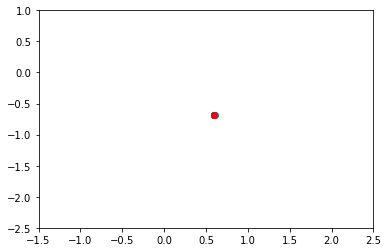

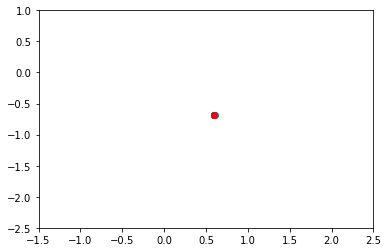

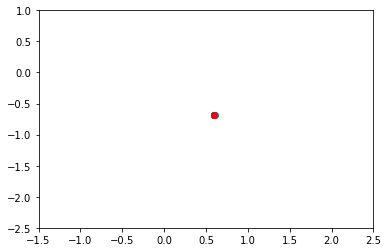

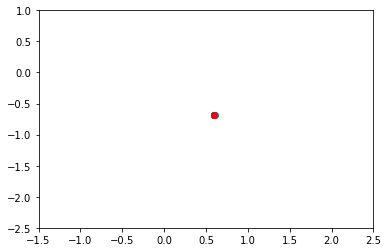

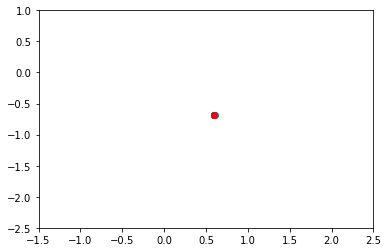

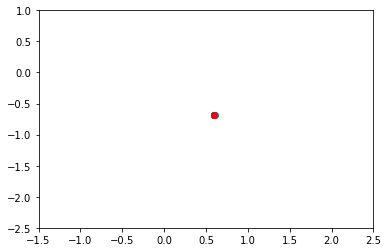

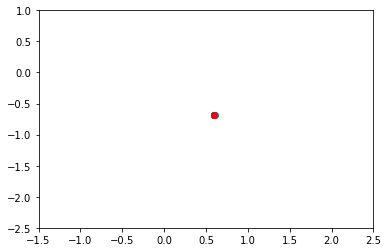

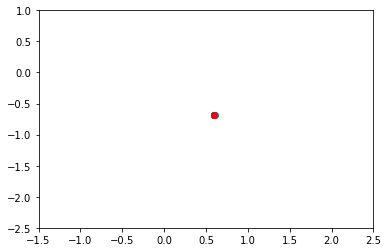

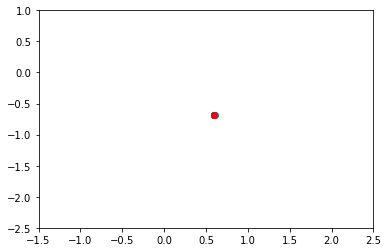

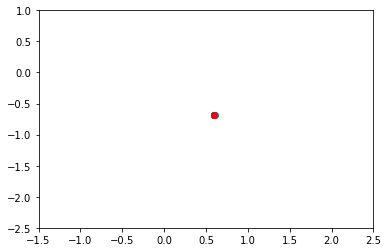

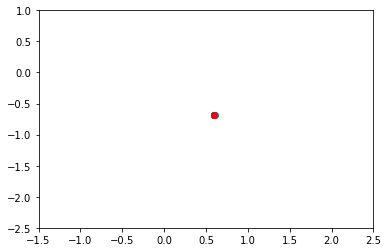

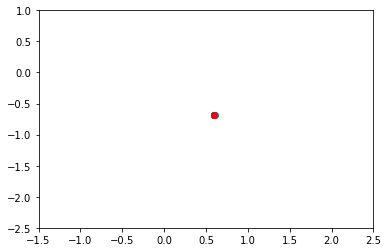

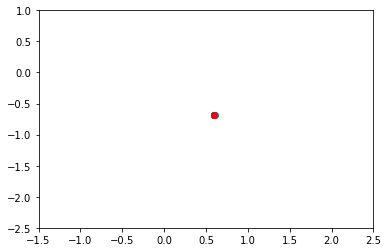

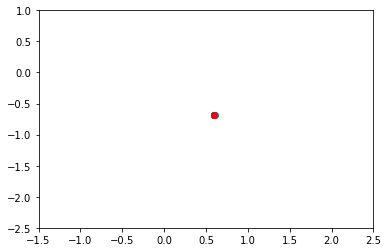

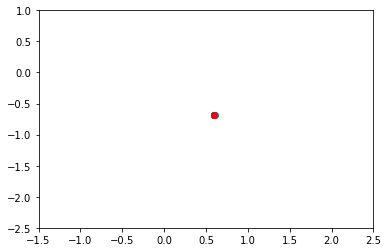

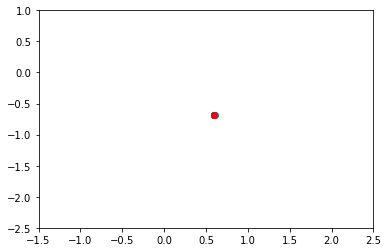

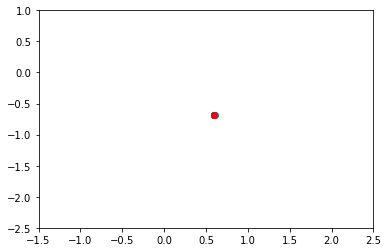

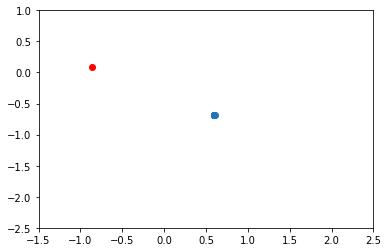

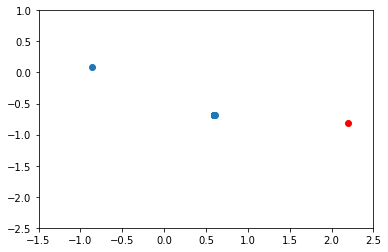

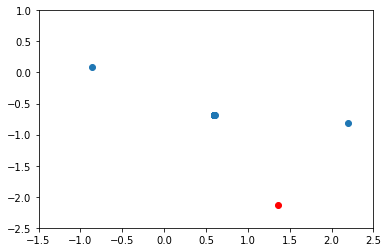

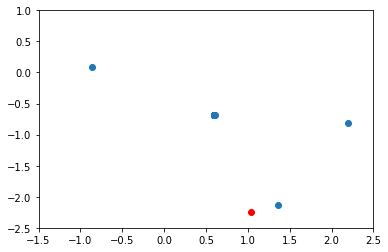

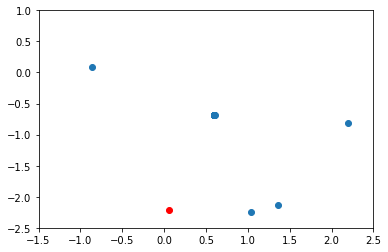

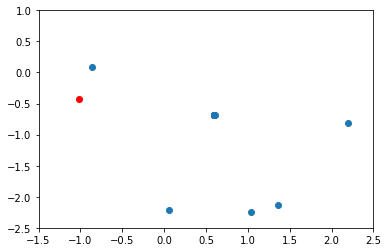

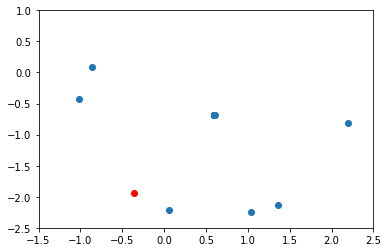

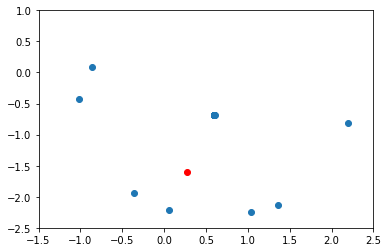

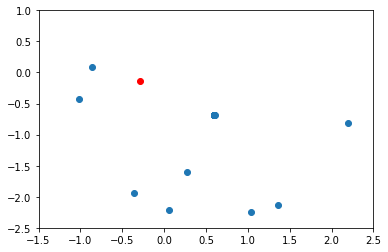

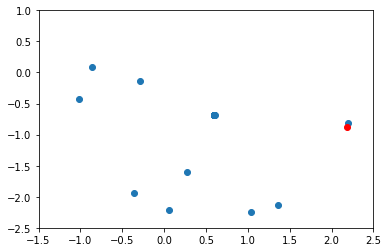

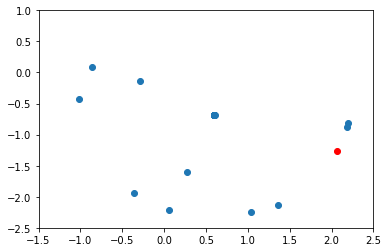

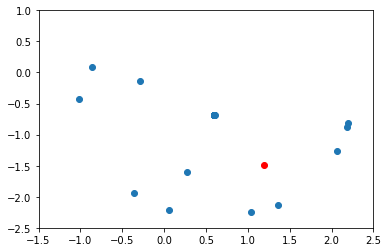

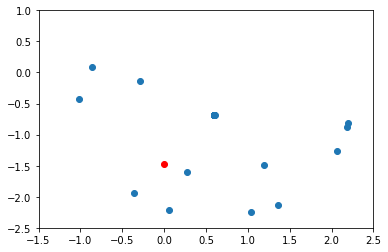

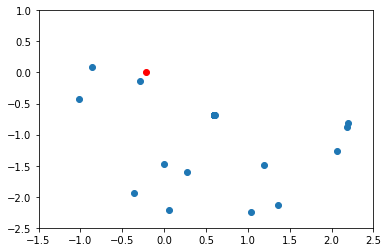

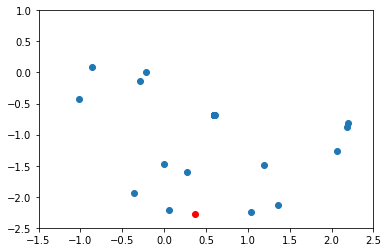

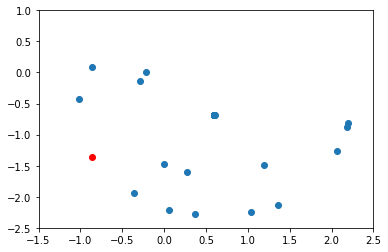

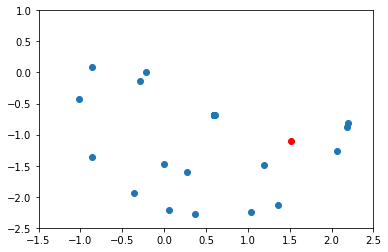

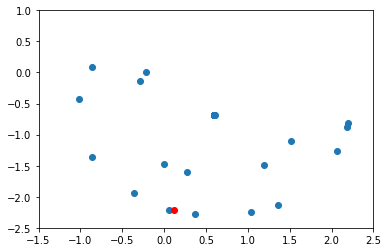

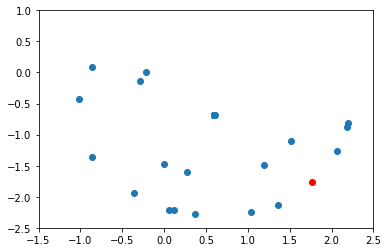

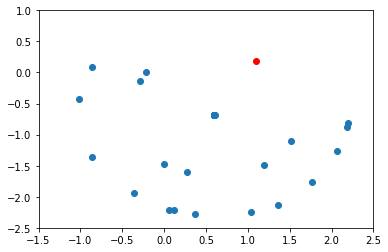

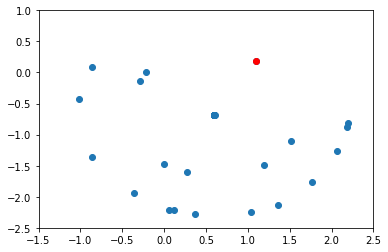

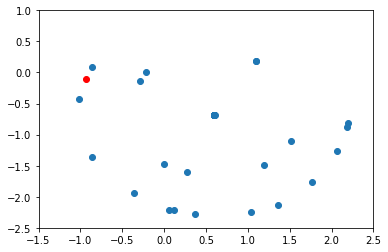

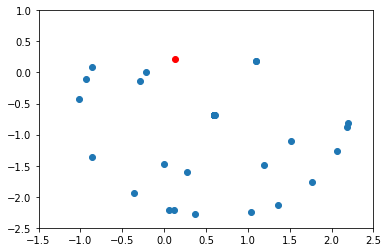

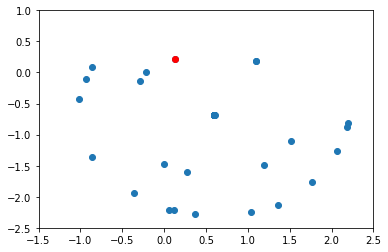

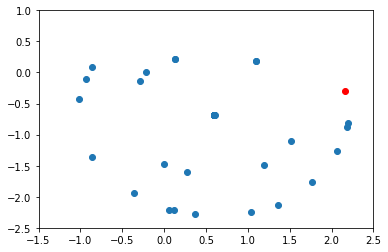

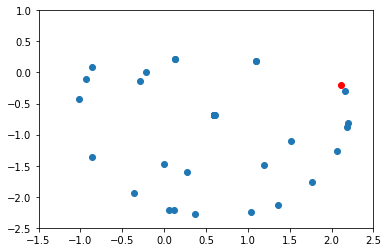

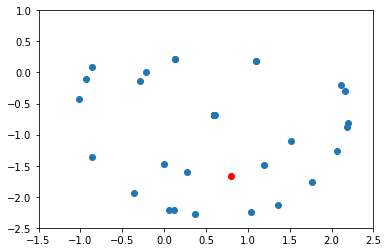

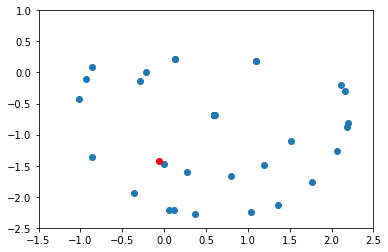

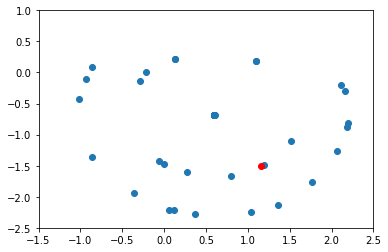

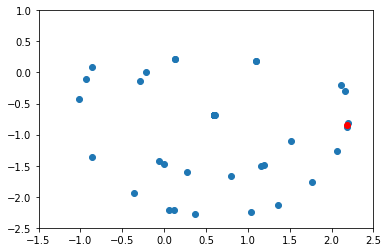

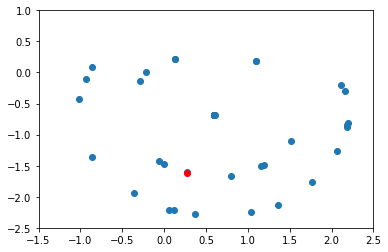

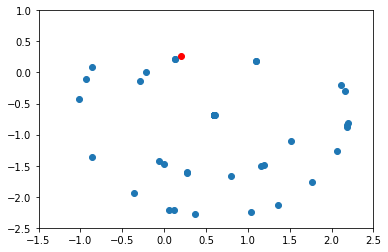

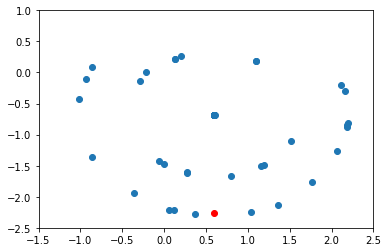

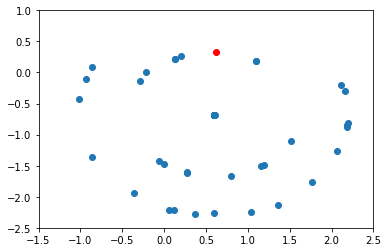

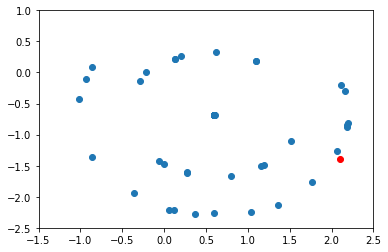

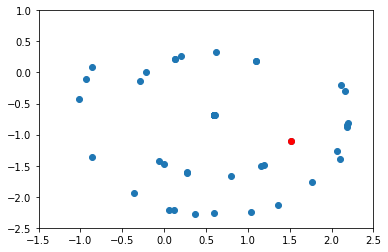

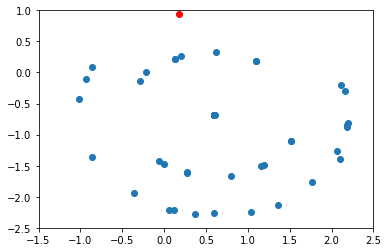

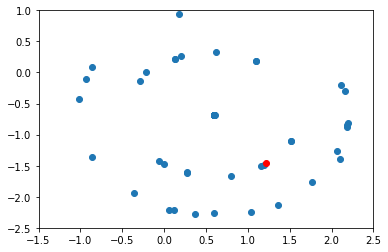

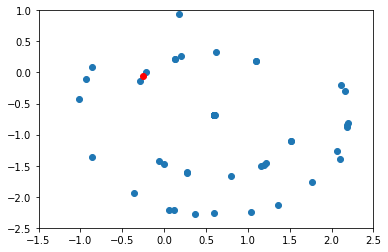

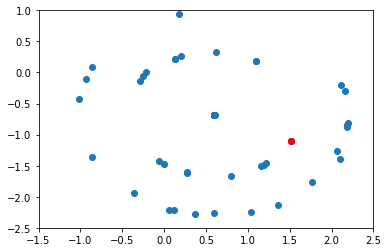

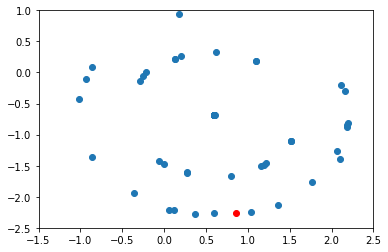

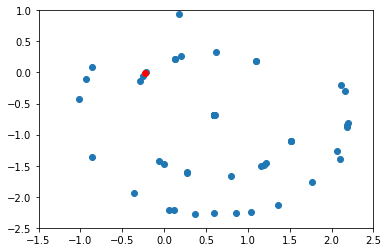

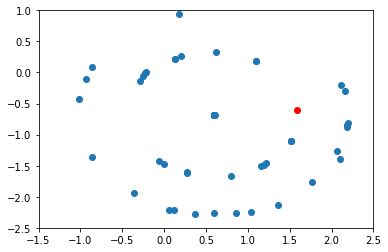

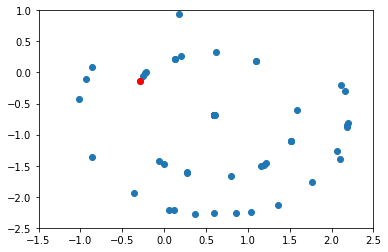

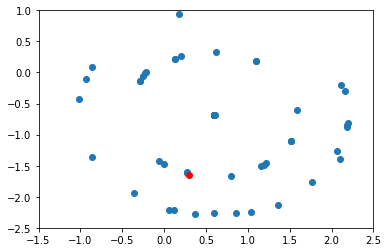

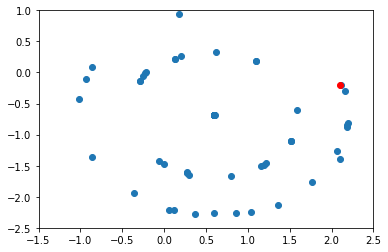

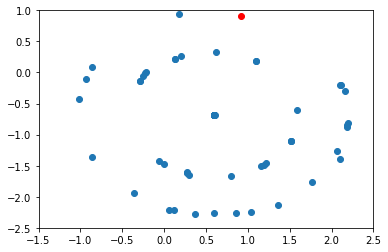

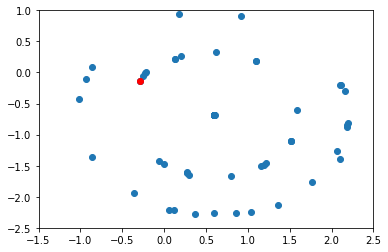

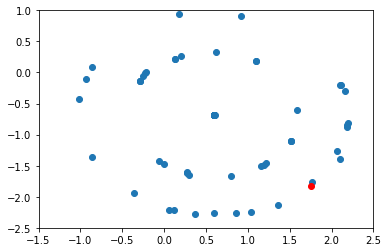

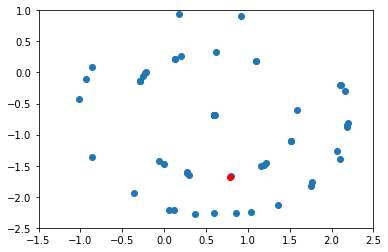

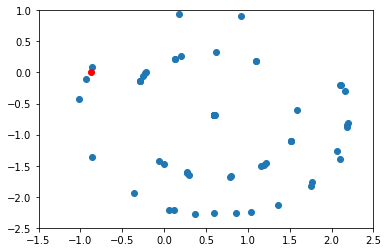

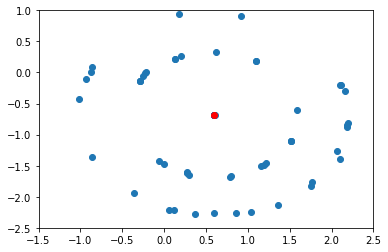

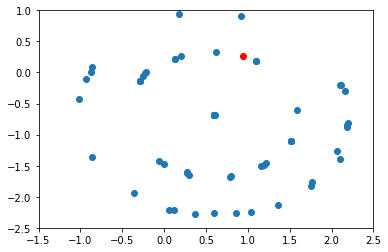

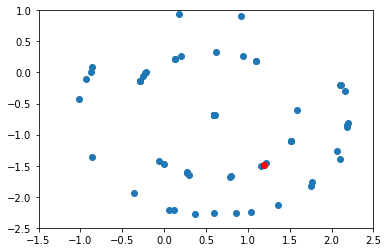

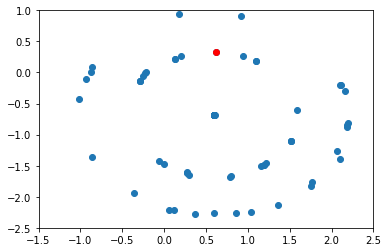

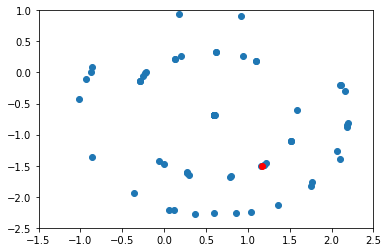

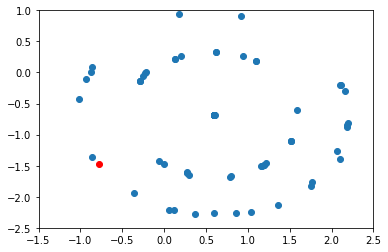

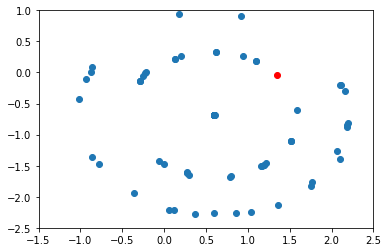

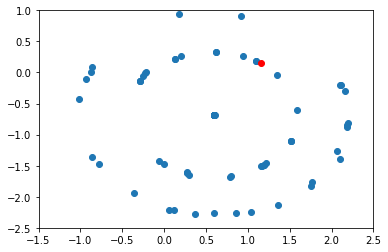

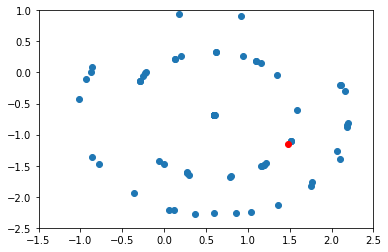

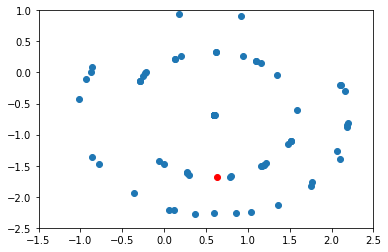

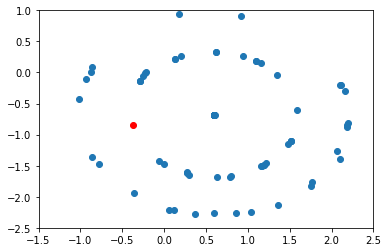

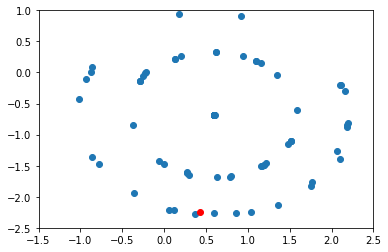

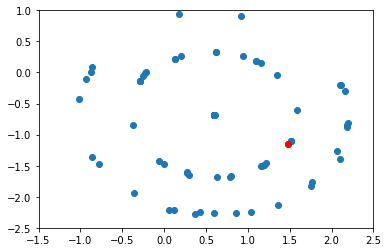

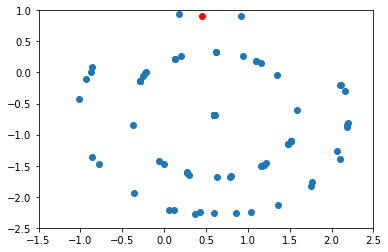

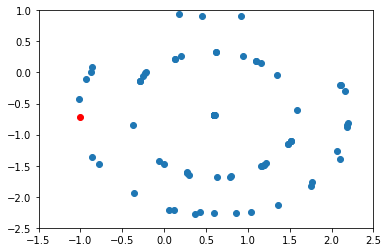

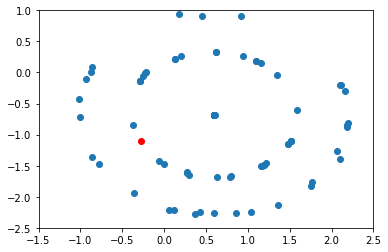

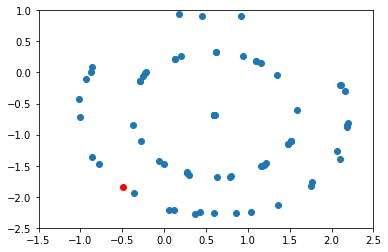

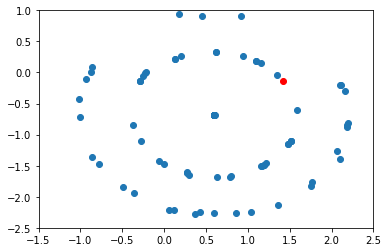

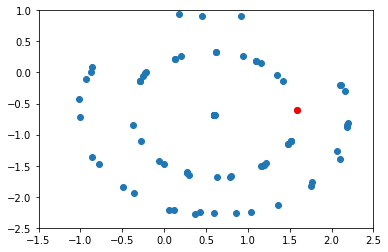

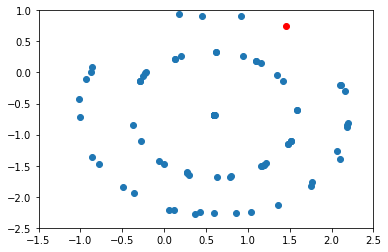

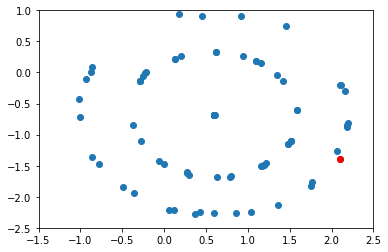

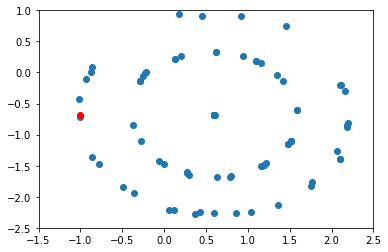

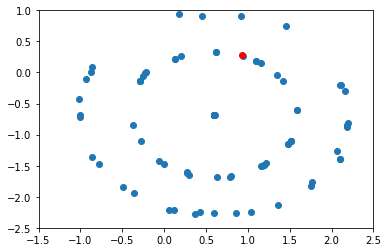

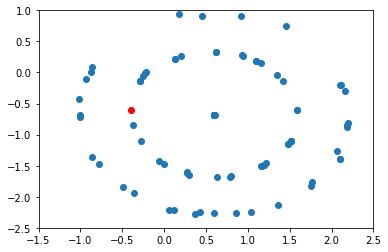

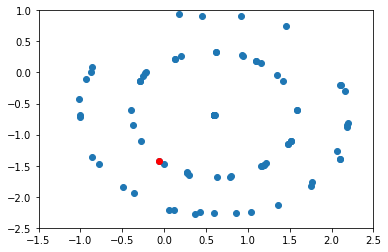

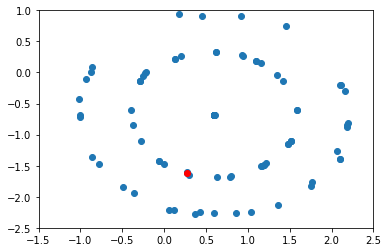

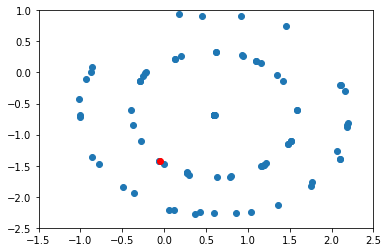

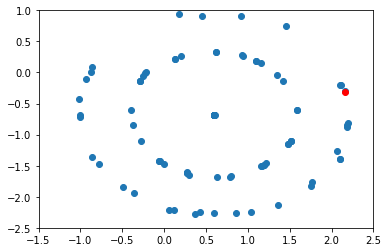

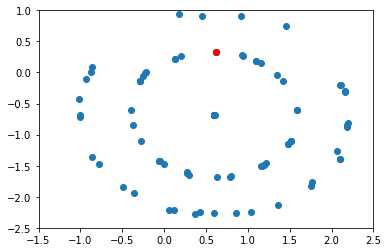

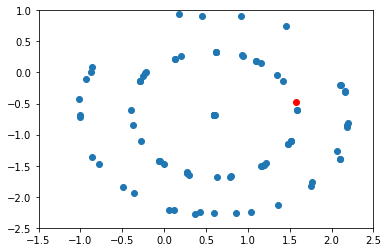

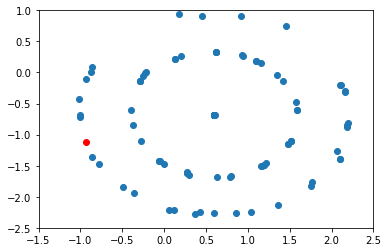

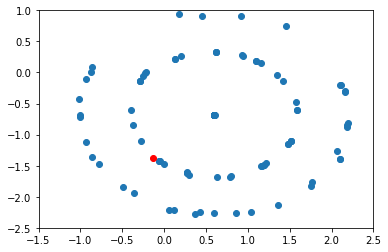

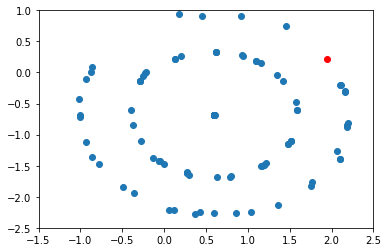

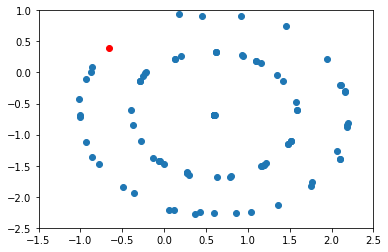

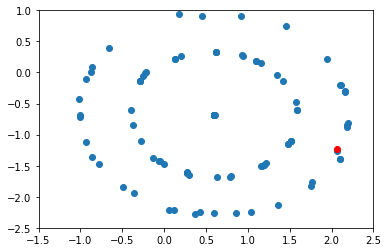

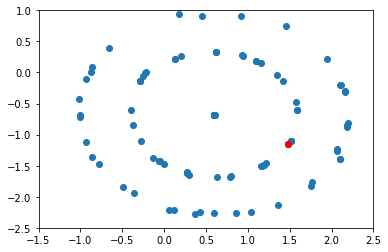

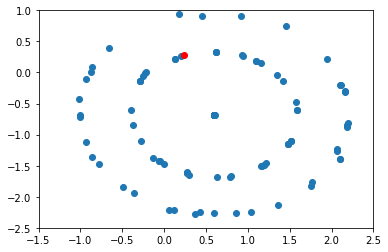

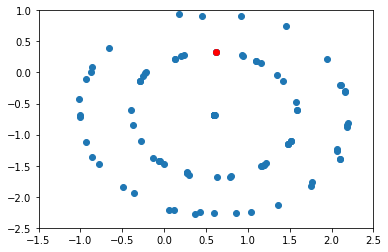

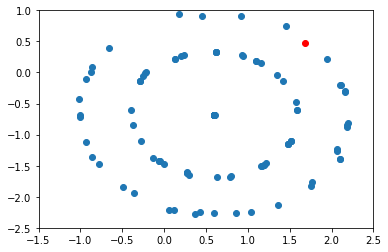

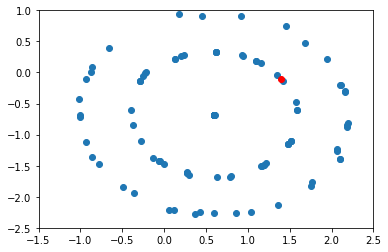

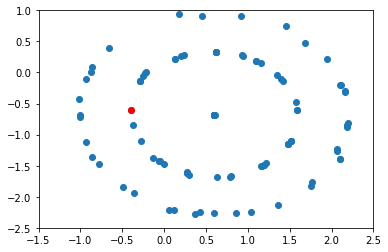

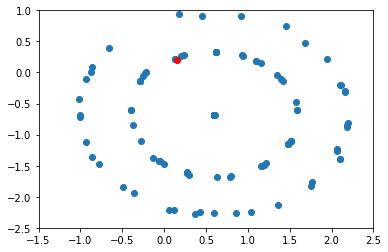

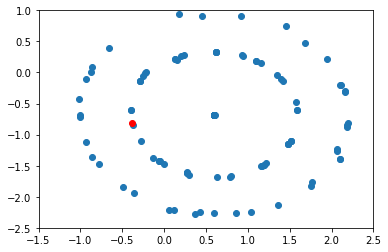

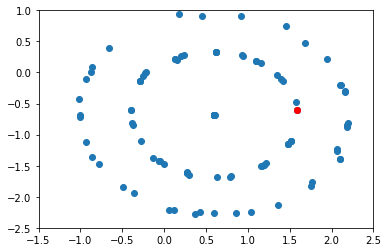

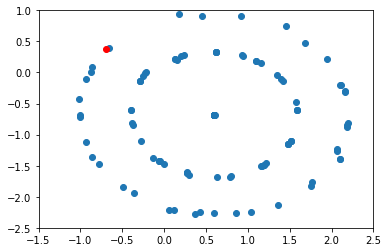

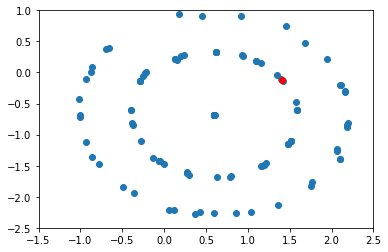

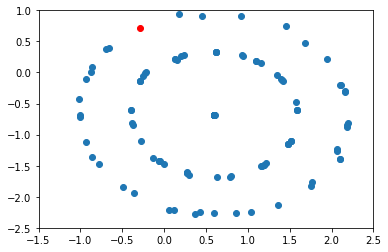

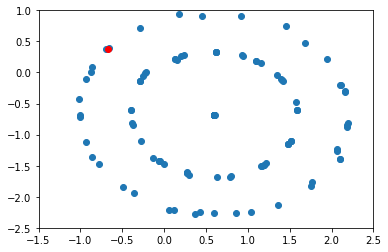

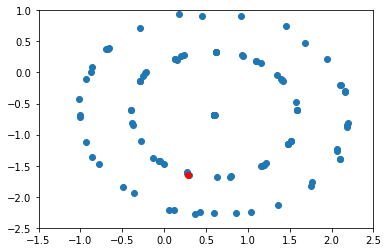

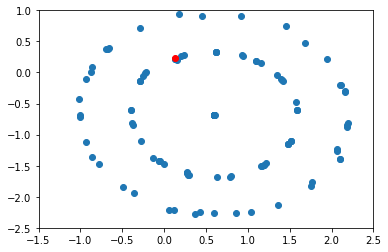

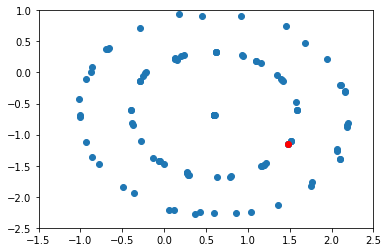

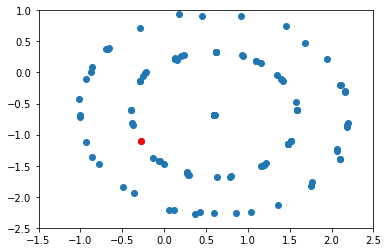

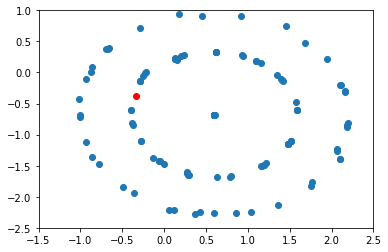

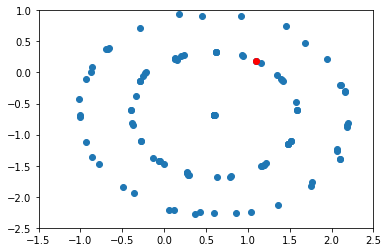

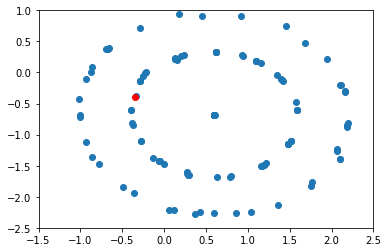

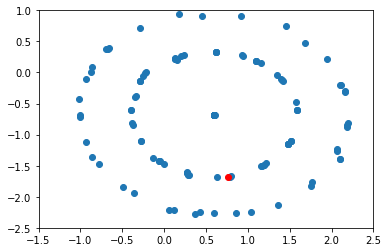

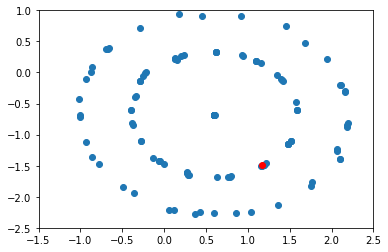

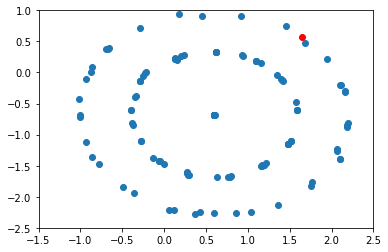

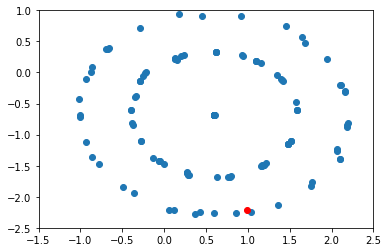

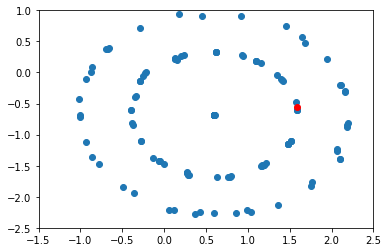

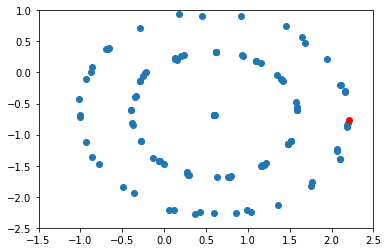

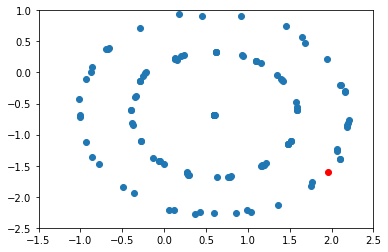

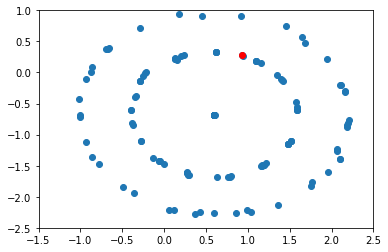

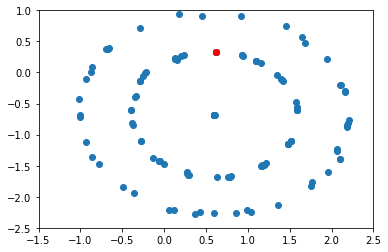

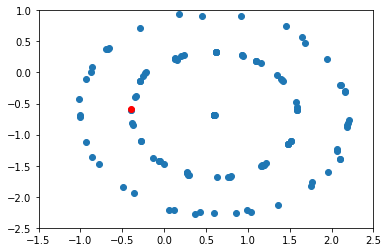

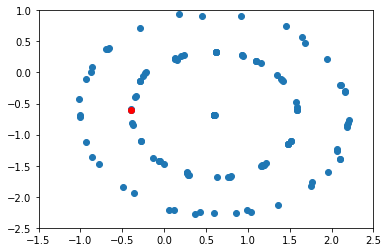

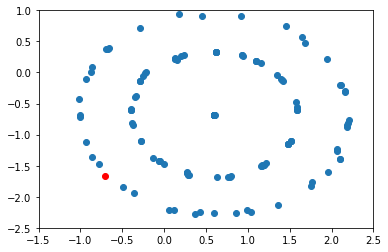

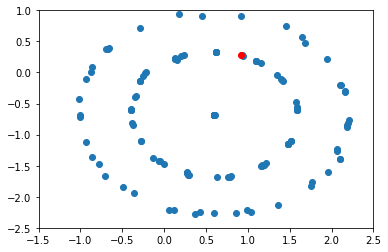

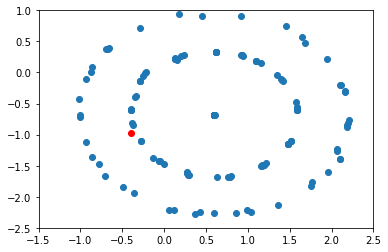

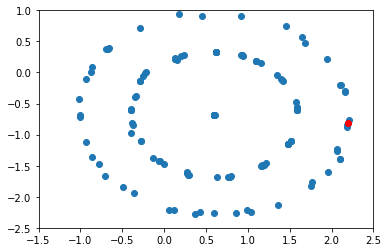

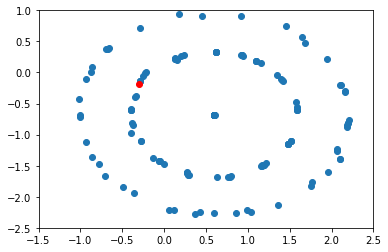

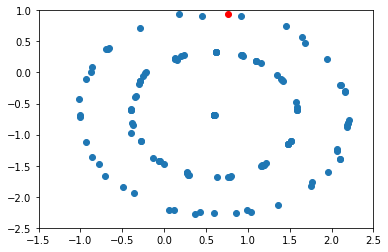

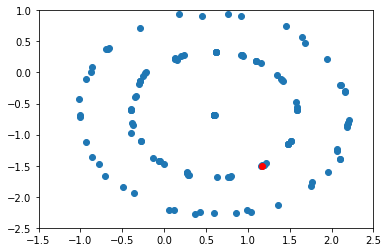

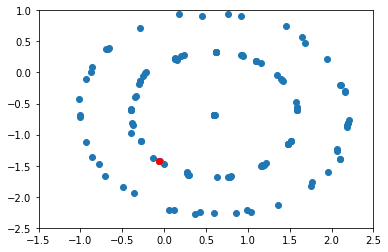

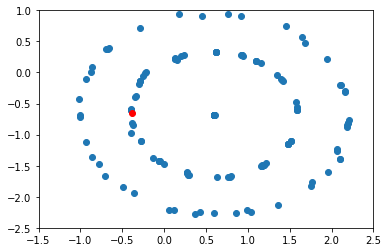

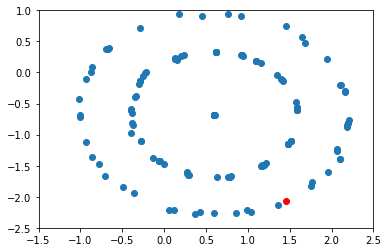

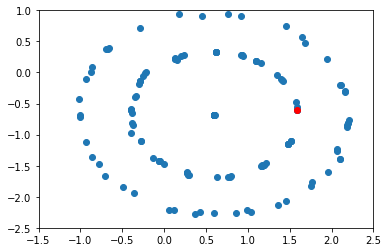

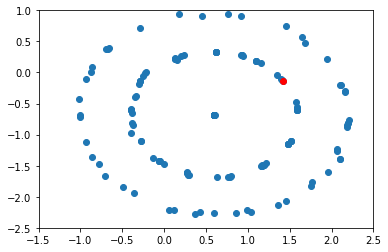

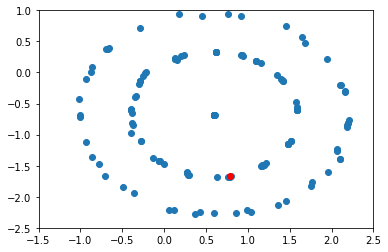

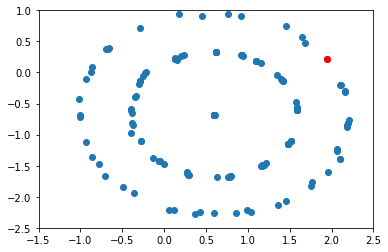

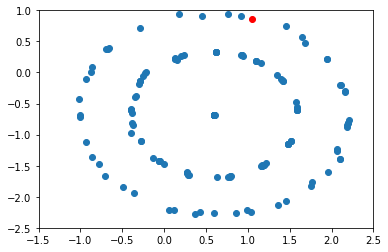

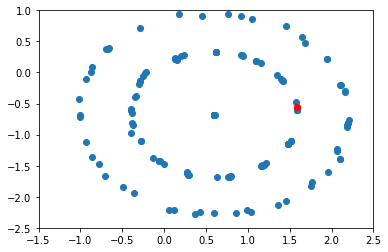

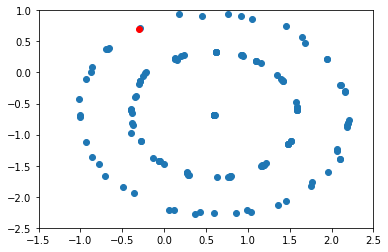

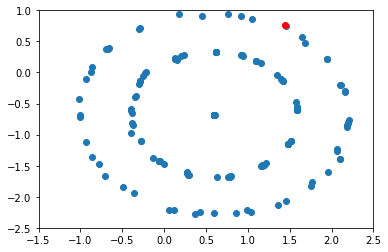

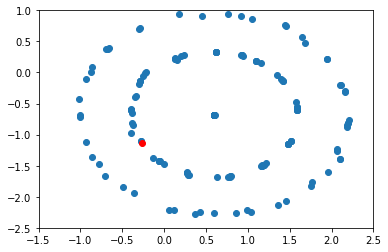

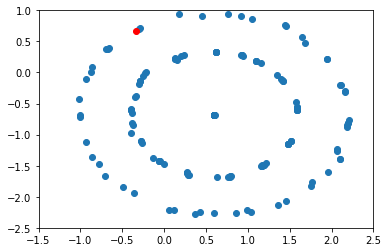

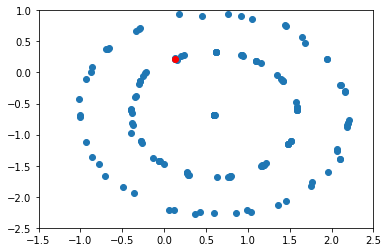

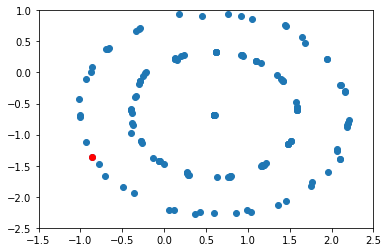

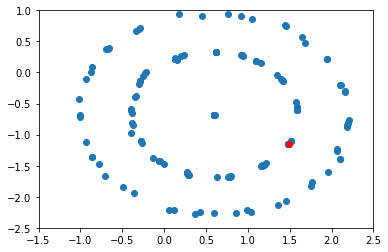

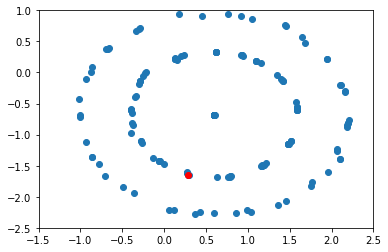

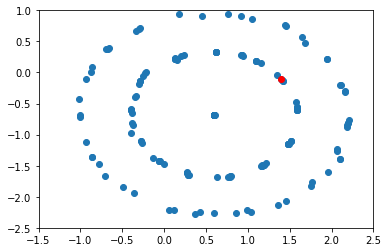

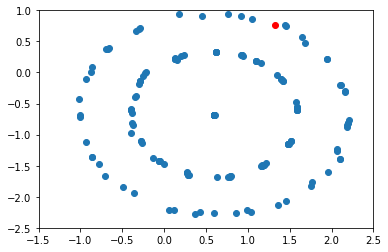

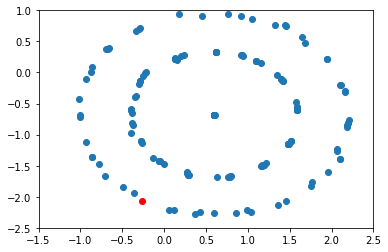

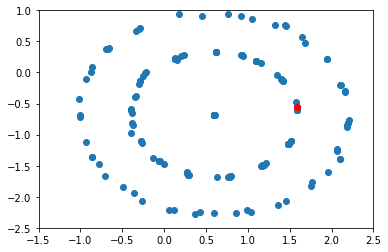

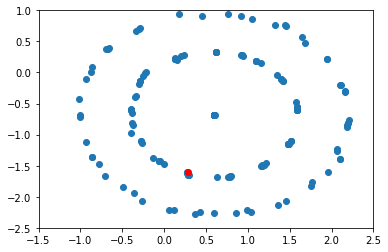

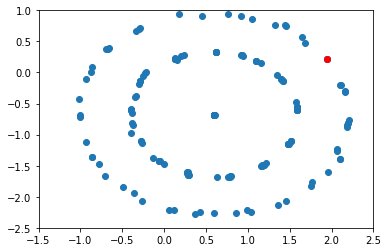

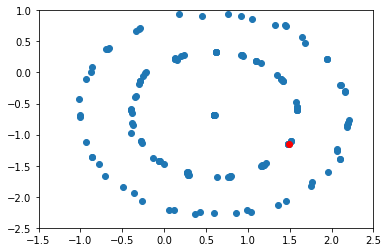

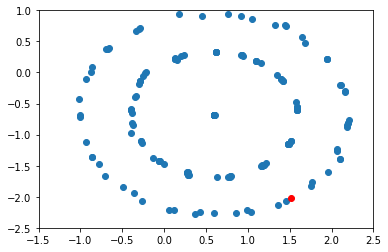

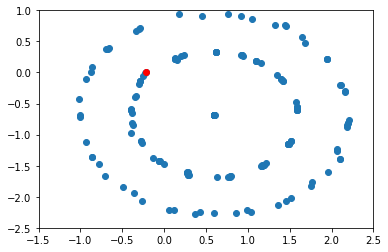

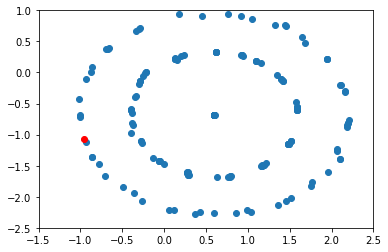

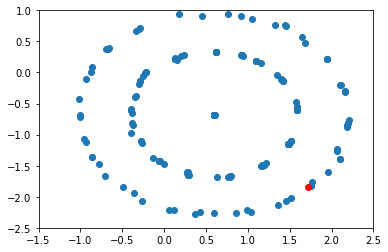

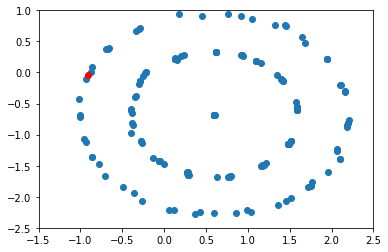

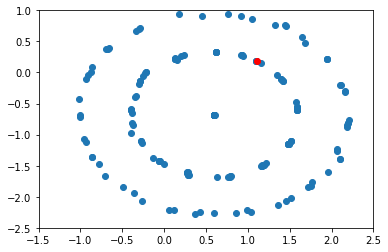

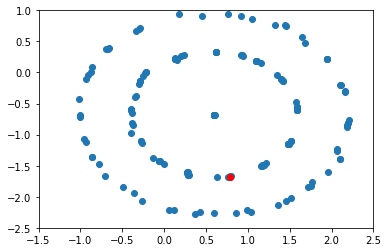

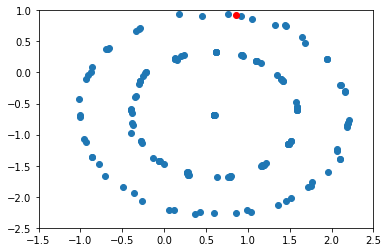

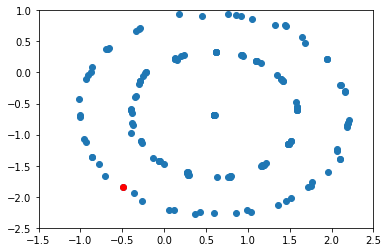

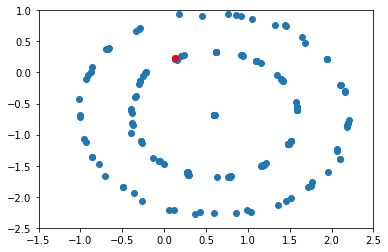

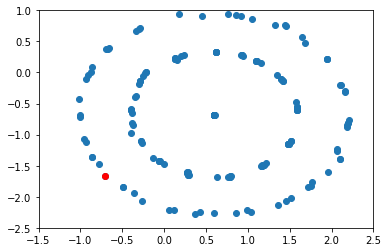

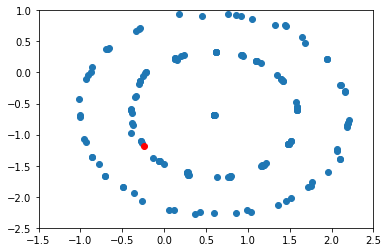

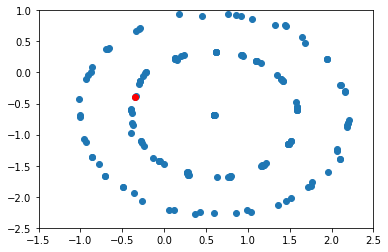

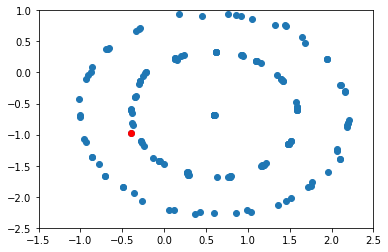

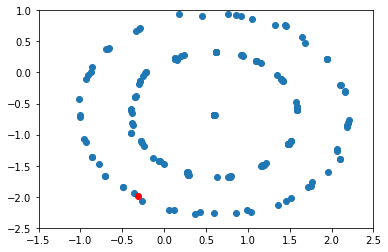

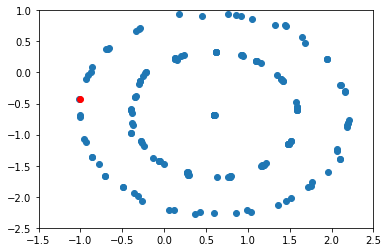

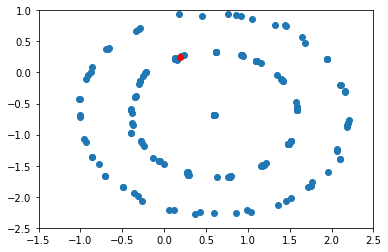

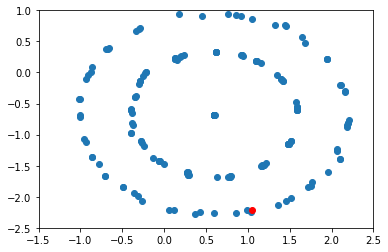

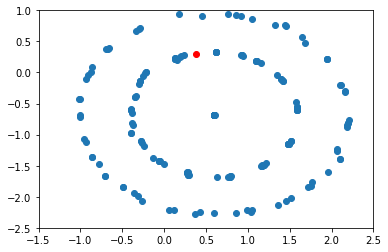

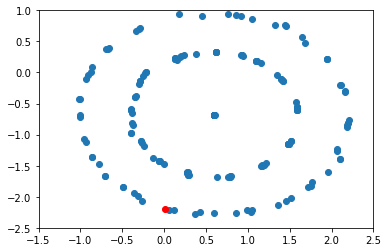

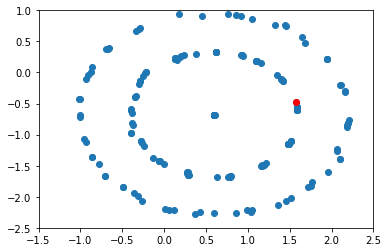

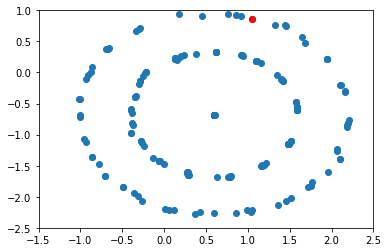

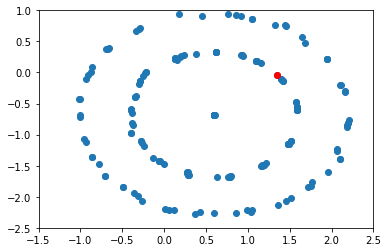

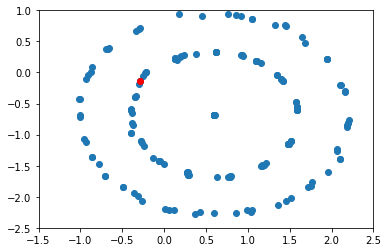

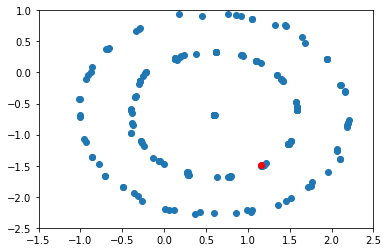

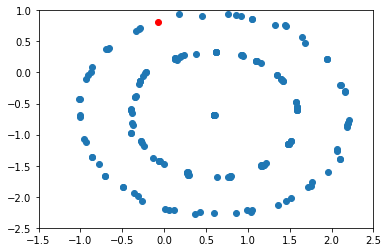

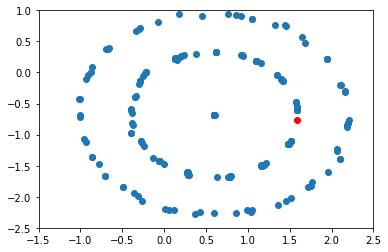

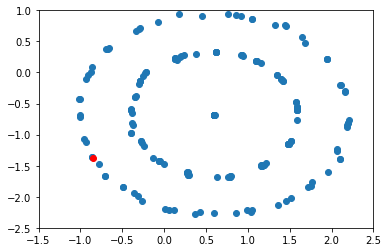

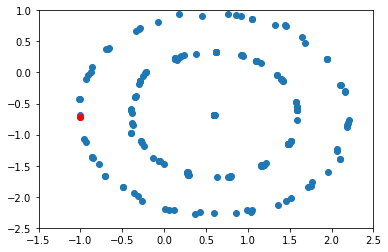

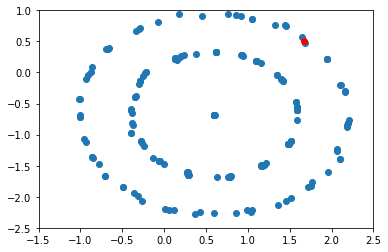

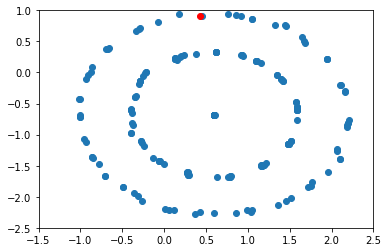

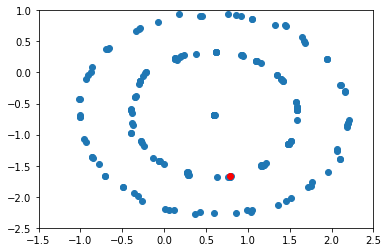

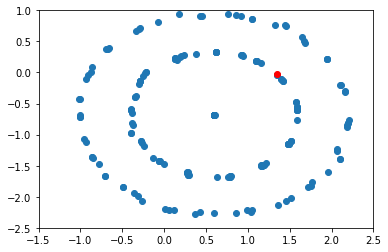

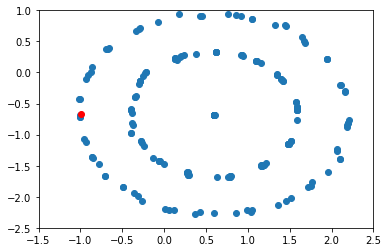

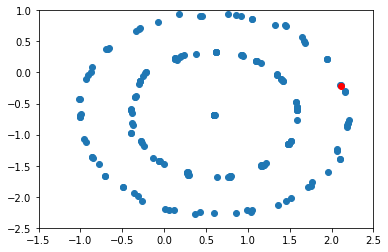

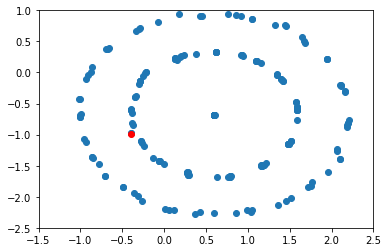

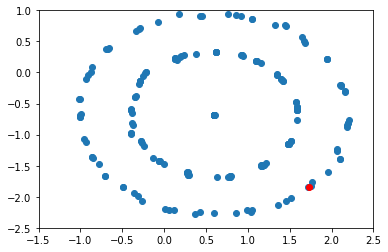

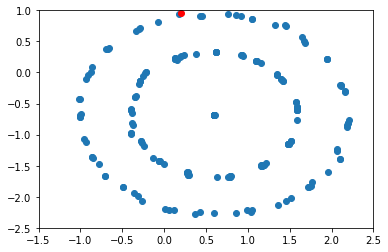

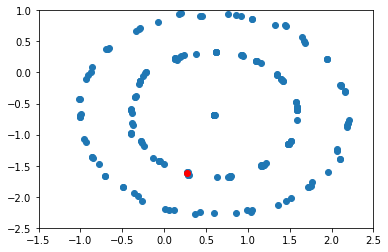

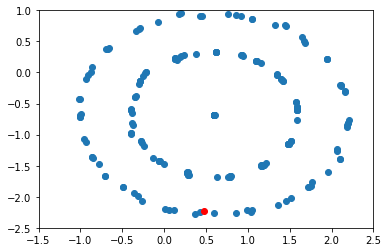

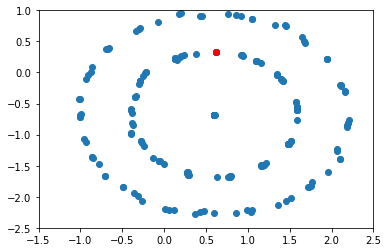

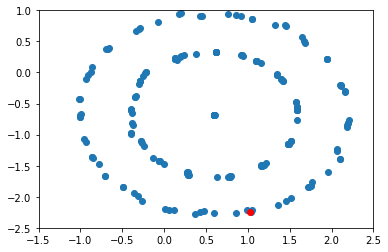

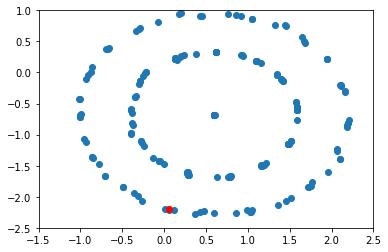

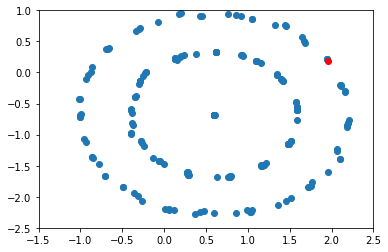

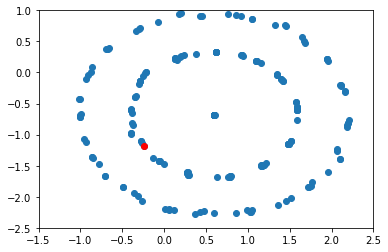

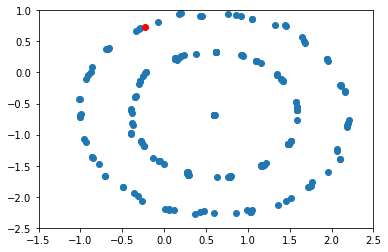

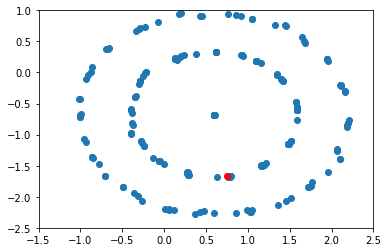

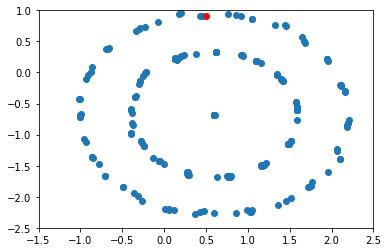

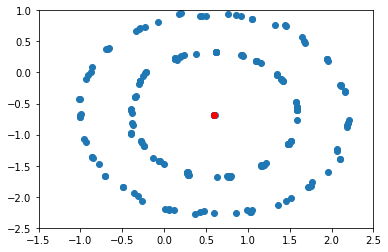

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images

for i in range(X_embedded.shape[0]):
    fig = plt.figure()
    plt.scatter(X_embedded[:i,0], X_embedded[:i,1])
    plt.scatter(X_embedded[i,0], X_embedded[i,1],c= "r")
    plt.xlim(-1.5,2.5)
    plt.ylim(-2.5,1)
    img.append(fig2img(fig))
 

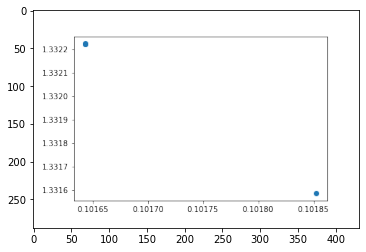

In [28]:
plt.imshow(img[4])

In [13]:
%matplotlib

fig = plt.figure()
viewer = fig.add_subplot(111)
plt.ion() # Turns interactive mode on (probably unnecessary)
fig.show() # Initially shows the figure

for i in range(len(img)):
    viewer.clear() # Clears the previous image
    viewer.imshow(img[i]) # Loads the new image
    plt.pause(.01) # Delay in seconds
    fig.canvas.draw() # Draws the image to the screen

Using matplotlib backend: TkAgg
